In [1]:
import pandas as pd
import numpy as np
from pyjet import cluster,DTYPE_PTEPM
from sklearn import preprocessing

# Pre processing

In [2]:
path = '/anomalyvol/data/events_LHCO2020_backgroundMC_Pythia.h5'

In [3]:
df = pd.read_hdf(path,stop=100000) # just read first 100000 events

In [4]:
all_events = df.values

In [5]:
rows = all_events.shape[0]
cols = all_events.shape[1]
data = []

In [6]:
for i in range(rows):
    pseudojets_input = np.zeros(len([x for x in all_events[i][::3] if x > 0]), dtype=DTYPE_PTEPM)
    for j in range(cols // 3):
        if (all_events[i][j*3]>0):
            pseudojets_input[j]['pT'] = all_events[i][j*3]
            pseudojets_input[j]['eta'] = all_events[i][j*3+1]
            pseudojets_input[j]['phi'] = all_events[i][j*3+2]
        pass
    sequence = cluster(pseudojets_input, R=1.0, p=-1)
    jets = sequence.inclusive_jets()
    for k in range(len(jets)):
        jet = []
        jet.append(jets[k].px)
        jet.append(jets[k].py)
        jet.append(jets[k].pz)
        jet.append(jets[k].e)
        data.append(jet)

In [7]:
data = np.array(data)
data.shape

(1477373, 4)

In [8]:
# log transform pT
#data[:,3] = np.ma.log(data[:,3]).filled()

In [9]:
data

array([[-1.17658220e+03, -7.79040316e+02,  3.40962660e+02,
         1.45491963e+03],
       [ 6.11088616e+02,  7.16513394e+02,  1.55833044e+03,
         1.87194199e+03],
       [ 4.96094722e+02, -1.87111748e+01,  1.78940558e+03,
         1.85808569e+03],
       ...,
       [ 4.42306312e-01,  9.70780337e-02,  2.58945478e+01,
         2.58985070e+01],
       [-2.68772115e-01, -3.44070287e-01, -3.01572220e+01,
         3.01603823e+01],
       [-2.82745626e-01, -7.48815701e-02, -9.38791569e+00,
         9.39247109e+00]])

In [10]:
# splitting data
x_train = data[0:int(len(data) * 0.8)]
x_val = data[int(len(data) * 0.8):int(len(data) * 0.9)]
x_test = data[int(len(data) * 0.9):]

In [11]:
# regularize
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# VAE Model

In [12]:
import keras
from keras.layers import Lambda, Input, Dense, Flatten, Reshape
from keras.models import Model, Sequential
from keras import metrics, losses
from keras import backend as K

Using TensorFlow backend.


In [13]:
def sampling(args):
    """
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [14]:
inter_dim_1 = 32
inter_dim_2 = 16
final_dim = 8
latent_dim = 4
input_dim = 4

In [15]:
# encoder
x = Input(shape=(input_dim,))
#x_flat = Flatten()(x)
h1 = Dense(inter_dim_1, activation='relu')(x)
h2 = Dense(inter_dim_2, activation='relu')(h1)
h3 = Dense(final_dim, activation='relu')(h2)
z_mean = Dense(latent_dim)(h3)
z_log_sigma = Dense(latent_dim)(h2)

In [16]:
# random sampling
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

encoder = Model(inputs = x, outputs = z)

In [17]:
# decoder
decoder_h3 = Dense(final_dim, activation='relu')
decoder_h2 = Dense(inter_dim_2, activation='relu')
decoder_h1 = Dense(inter_dim_1, activation='relu')
decoder_mean = Dense(input_dim, activation='linear')

h3_decoded = decoder_h3(z)
h2_decoded = decoder_h2(h3_decoded)
h1_decoded = decoder_h1(h2_decoded)
x_decoded_mean = decoder_mean(h1_decoded)
# x_decoded = Reshape(input_shape)(x_decoded_mean)

In [18]:
vae = Model(inputs = x, outputs = x_decoded_mean, name = 'vae')

In [19]:
mse = keras.losses.MeanSquaredError()
def vae_loss(x, y):
    mse_loss = mse(x, y)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return mse_loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss)

In [20]:
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           160         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 16)           528         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 8)            136         dense_2[0][0]                    
________________________________________________________________________________________________

# Train

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
batch_size = 1000
epochs = 100

In [23]:
x_train.shape

(1181898, 4)

In [24]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=10)
]

In [25]:
hist = vae.fit(x_train, x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_val, x_val),
               callbacks=my_callbacks)

Train on 1181898 samples, validate on 147737 samples
Epoch 1/100
1181898/1181898 [==============================] - 9s 8us/step - loss: 0.6776 - val_loss: 0.5463
Epoch 2/100
1181898/1181898 [==============================] - 8s 7us/step - loss: 0.4521 - val_loss: 0.4174
Epoch 3/100
1181898/1181898 [==============================] - 8s 7us/step - loss: 0.4128 - val_loss: 0.4090
Epoch 4/100
1181898/1181898 [==============================] - 8s 7us/step - loss: 0.4062 - val_loss: 0.4042
Epoch 5/100
1181898/1181898 [==============================] - 9s 7us/step - loss: 0.4026 - val_loss: 0.4032
Epoch 6/100
1181898/1181898 [==============================] - 8s 7us/step - loss: 0.4005 - val_loss: 0.4030
Epoch 7/100
1181898/1181898 [==============================] - 8s 7us/step - loss: 0.3995 - val_loss: 0.3972
Epoch 8/100
1181898/1181898 [==============================] - 8s 7us/step - loss: 0.3977 - val_loss: 0.4000
Epoch 9/100
1181898/1181898 [==============================] - 8s 7us/step 

# Visualization

In [26]:
import matplotlib.pyplot as plt

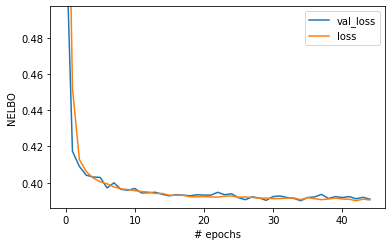

In [27]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())
plt.show()

In [28]:
predictions = vae.predict(x_test)

In [29]:
predictions

array([[-0.00670008,  0.00755446, -0.00491068, -0.3855221 ],
       [-0.01710073,  0.00179731, -0.003254  , -0.39385688],
       [-0.00637177,  0.00769444, -0.00524381, -0.3862079 ],
       ...,
       [-0.00895051,  0.00327899, -0.00509534, -0.3851958 ],
       [-0.01019279,  0.01183398, -0.00668299, -0.3861016 ],
       [-0.01441649, -0.00214208, -0.01152633, -0.3976469 ]],
      dtype=float32)

In [30]:
distr = (x_test - predictions) / x_test

In [31]:
px_pred = [row[0] for row in predictions]
py_pred = [row[1] for row in predictions]
pz_pred = [row[2] for row in predictions]
e_pred = [row[3] for row in predictions]

In [32]:
px = [row[0] for row in x_test]
py = [row[1] for row in x_test]
pz = [row[2] for row in x_test]
e = [row[3] for row in x_test]

## Stacking output (orange) over input (blue) for pT, eta, phi, m

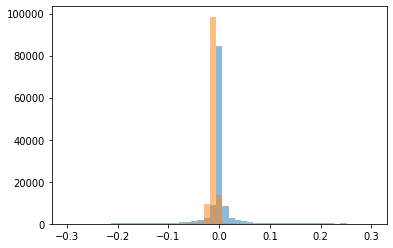

In [33]:
bins = np.linspace(-0.3, 0.3, 50)
plt.hist(px, bins=bins,alpha=0.5)
plt.hist(px_pred, bins=bins,alpha=0.5)
bins = np.linspace(-0.45, -0.2, 40)

(array([3.7000e+01, 3.8000e+01, 4.4000e+01, 3.7000e+01, 5.0000e+01,
        3.8000e+01, 4.4000e+01, 4.8000e+01, 4.5000e+01, 6.4000e+01,
        5.8000e+01, 5.5000e+01, 5.3000e+01, 5.4000e+01, 7.7000e+01,
        8.4000e+01, 1.2700e+02, 1.4400e+02, 1.9900e+02, 2.0900e+02,
        3.3000e+02, 4.9500e+02, 9.2300e+02, 5.7880e+03, 8.3424e+04,
        3.2356e+04, 3.7900e+02, 1.8000e+02, 1.3900e+02, 9.0000e+01,
        7.9000e+01, 8.1000e+01, 7.5000e+01, 6.8000e+01, 7.8000e+01,
        6.5000e+01, 6.9000e+01, 6.5000e+01, 7.1000e+01, 5.8000e+01,
        5.7000e+01, 6.8000e+01, 6.3000e+01, 5.1000e+01, 5.3000e+01,
        5.8000e+01, 6.0000e+01, 4.4000e+01, 5.3000e+01]),
 array([-0.3       , -0.2877551 , -0.2755102 , -0.26326531, -0.25102041,
        -0.23877551, -0.22653061, -0.21428571, -0.20204082, -0.18979592,
        -0.17755102, -0.16530612, -0.15306122, -0.14081633, -0.12857143,
        -0.11632653, -0.10408163, -0.09183673, -0.07959184, -0.06734694,
        -0.05510204, -0.04285714, -0.0

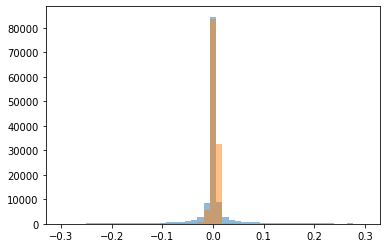

In [34]:
bins = np.linspace(-0.3, 0.3, 50)
plt.hist(py, bins=bins,alpha=0.5)
plt.hist(py_pred, bins=bins,alpha=0.5)

(array([6.7000e+01, 4.9000e+01, 5.6000e+01, 5.3000e+01, 4.6000e+01,
        5.6000e+01, 6.4000e+01, 5.4000e+01, 6.4000e+01, 7.4000e+01,
        6.4000e+01, 7.8000e+01, 8.8000e+01, 9.4000e+01, 1.0300e+02,
        1.2000e+02, 1.4700e+02, 1.9300e+02, 2.3100e+02, 2.2900e+02,
        3.4800e+02, 6.3000e+02, 1.7300e+03, 6.5411e+04, 5.5099e+04,
        5.3800e+02, 3.8500e+02, 2.8700e+02, 1.9800e+02, 1.3000e+02,
        1.3700e+02, 1.2600e+02, 1.0100e+02, 8.2000e+01, 8.8000e+01,
        7.1000e+01, 8.0000e+01, 7.2000e+01, 8.1000e+01, 7.6000e+01,
        6.9000e+01, 6.9000e+01, 6.2000e+01, 7.2000e+01, 6.7000e+01,
        5.6000e+01, 6.8000e+01, 6.0000e+01, 6.1000e+01]),
 array([-0.3       , -0.2877551 , -0.2755102 , -0.26326531, -0.25102041,
        -0.23877551, -0.22653061, -0.21428571, -0.20204082, -0.18979592,
        -0.17755102, -0.16530612, -0.15306122, -0.14081633, -0.12857143,
        -0.11632653, -0.10408163, -0.09183673, -0.07959184, -0.06734694,
        -0.05510204, -0.04285714, -0.0

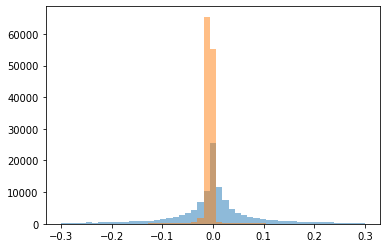

In [35]:
bins = np.linspace(-0.3, 0.3, 50)
plt.hist(pz, bins=bins,alpha=0.5)
plt.hist(pz_pred, bins=bins,alpha=0.5)

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 9.00000e+00, 1.22359e+05,
        2.23400e+03, 2.14000e+02, 1.72000e+02, 9.90000e+01, 1.10000e+02,
        6.90000e+01, 5.90000e+01, 6.20000e+01, 5.70000e+01, 5.50000e+01,
        5.00000e+01, 6.80000e+01, 7.90000e+01, 9.80000e+01, 1.33000e+02,
        1.41000e+02, 2.13000e+02, 2.98000e+02, 3.85000e+02, 5.36000e+02,
        7.28000e+02, 8.53000e+02, 1.08700e+03, 1.35800e+03, 1.45800e+03,
        1.44000e+03, 1.41100e+03, 1.32800e+03, 1.14600e+03]),
 array([-2.        , -1.91836735, -1.83673469, -1.75510204, -1.67346939,
        -1.59183673, -1.51020408, -1.42857143, -1.34693878, -1.26530612,
        -1.18367347, -1.10204082, -1.02040816, -0.93877551, -0.85714286,
        -0.7755102 , -0.69387755, -0.6122449 , -0.53061224, -0

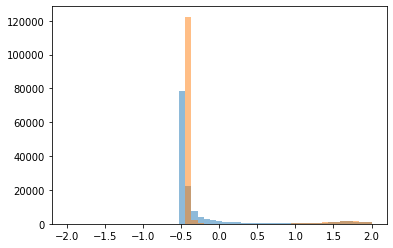

In [36]:
bins = np.linspace(-2,2, 50)
plt.hist(e, bins=bins,alpha=0.5)
plt.hist(e_pred, bins=bins,alpha=0.5)

In [37]:
d_px = [row[0] for row in distr]
d_py = [row[1] for row in distr]
d_pz = [row[2] for row in distr]
d_e = [row[3] for row in distr]

## Distribution of (input - output) / input

In [38]:
bins = np.linspace(-2, 2, 30)

(array([ 734.,  720.,  733.,  757.,  843.,  933.,  949.,  994., 1062.,
        1136., 1307., 1562., 2117., 3190., 4843., 5325., 3937., 2905.,
        2564., 2761., 3614., 6524., 4362., 2650., 2024., 1637., 1417.,
        1306., 1271.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

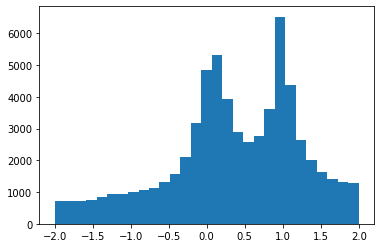

In [39]:
plt.hist(d_px, bins=bins)

(array([  655.,   681.,   754.,   773.,   786.,   875.,   924.,  1029.,
         1078.,  1370.,  1453.,  1793.,  2466.,  3681.,  5632.,  5457.,
         4319.,  3705.,  3569.,  4061.,  5706., 16331.,  7961.,  4374.,
         3221.,  2606.,  2184.,  1819.,  1704.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

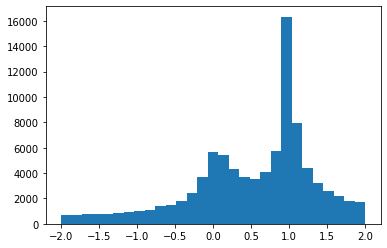

In [40]:
plt.hist(d_py, bins=bins)

(array([  254.,   298.,   292.,   372.,   426.,   449.,   532.,   599.,
          680.,   811.,  1011.,  1296.,  1858.,  2899.,  4631.,  5205.,
         4388.,  4102.,  4316.,  6462., 11335., 31966., 18251.,  8088.,
         4683.,  3077.,  2353.,  1908.,  1592.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

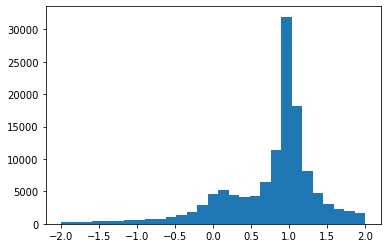

In [41]:
plt.hist(d_pz, bins=bins)